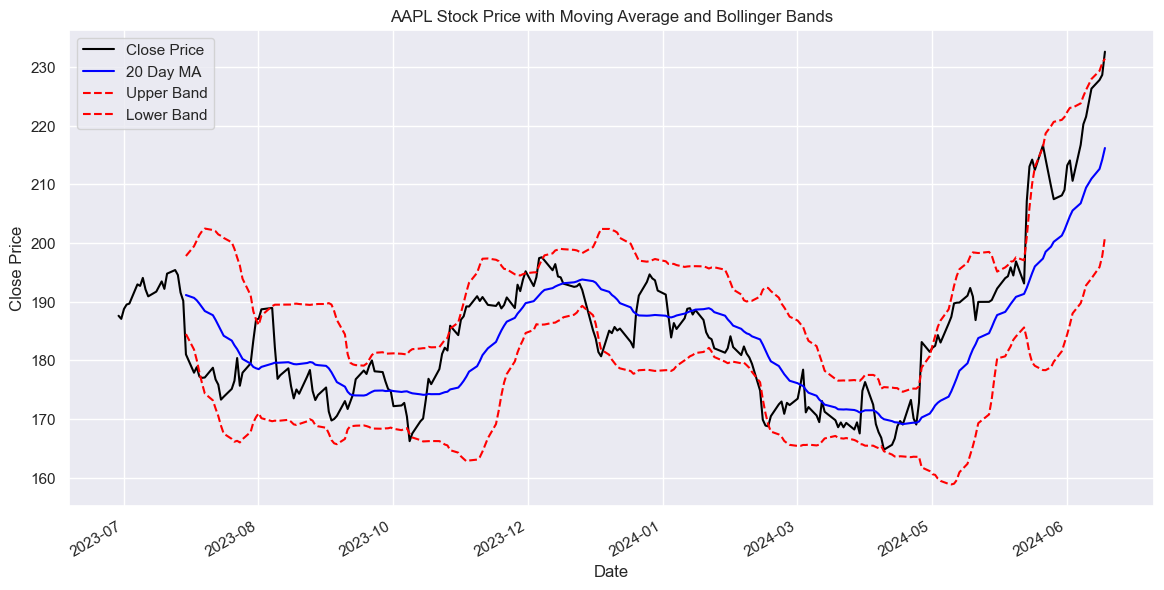

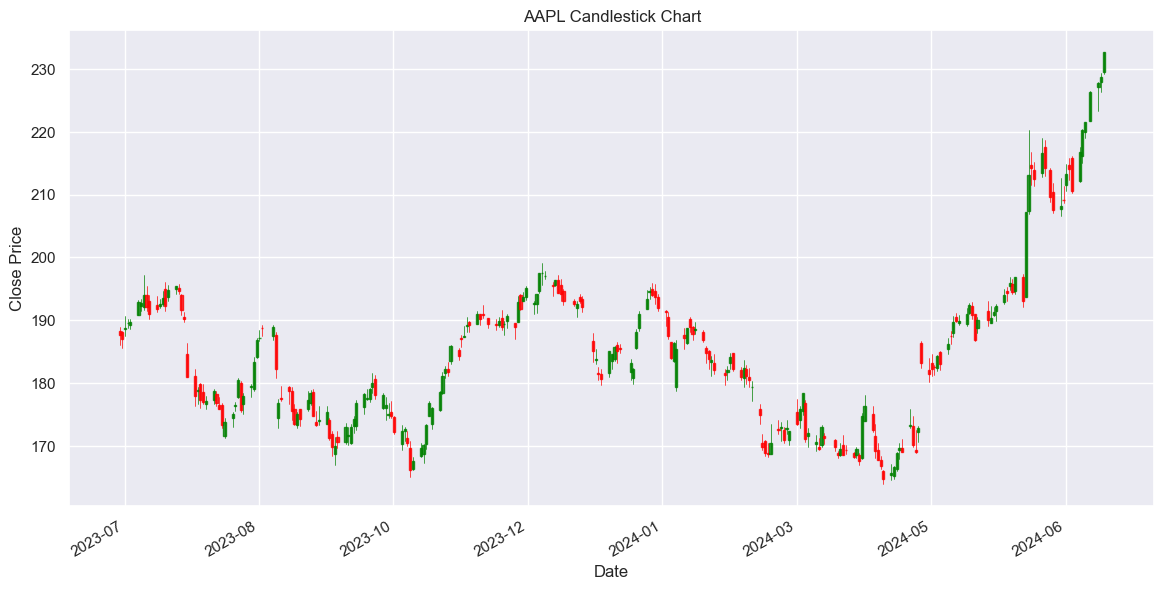

Financial Ratios for AAPL:
                       Value
P/E Ratio              36.78
Operating Cash Flow  110.54B
Free Cash Flow        99.58B
EBITDA               100.93B

Latest News:
Title: Investors won't want to own Apple in four years: Analyst
Description: Apple (AAPL) shares are rising to intraday highs as investors digest the tech giant's newly announced AI initiatives. Needham senior media and internet...
URL: https://finance.yahoo.com/video/investors-avoid-apple-four-years-202559723.html

Title: Apple wants to redefine AI as 'Apple intelligence' at WWDC
Description: Apple's (AAPL) Worldwide Developers Conference kicks off this week, spanning from Monday, June 10 to Friday, June 14. The iPhone maker is expected to...
URL: https://finance.yahoo.com/video/apple-wants-redefine-ai-apple-141722086.html

Title: Apple stock hits record high as investors react to Apple Intelligence announcements
Description: Apple investors are reacting strongly to the company’s WWDC announcements, wi

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
from datetime import datetime
import numpy as np
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.ticker as mticker

# Suppress FutureWarning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to get competitors from Financial Modeling Prep API
def get_competitors(ticker, fmp_api_key):
    stock = yf.Ticker(ticker)
    sector = stock.info.get('sector')
    industry = stock.info.get('industry')
    
    if not sector or not industry:
        raise ValueError(f"Sector or industry information not available for {ticker}")
    
    print(f"Sector: {sector}, Industry: {industry}")
    
    # Fetch all tickers in the same industry
    url = f'https://financialmodelingprep.com/api/v3/stock-screener?industry={industry}&apikey={fmp_api_key}'
    response = requests.get(url).json()
    competitors = [comp['symbol'] for comp in response if comp['symbol'] != ticker]
    
    print(f"Competitors found: {competitors}")
    return competitors

# Function to get financial data and calculate ratios
def get_financial_ratios(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    cashflow = stock.cashflow
    financials = stock.financials

    # Ensure correct labels for cashflow data
    if 'Operating Cash Flow' in cashflow.index:
        operating_cash_flow = cashflow.loc['Operating Cash Flow'].iloc[0]
    else:
        raise KeyError("Operating cash flow key not found in the cashflow data.")

    if 'Capital Expenditure' in cashflow.index:
        capital_expenditures = cashflow.loc['Capital Expenditure'].iloc[0]
    else:
        raise KeyError("Capital expenditures key not found in the cashflow data.")

    free_cash_flow = operating_cash_flow + capital_expenditures

    if 'Net Income' in financials.index:
        net_income = financials.loc['Net Income'].iloc[0]
    else:
        raise KeyError("Net income key not found in the financial data.")

    if 'Interest Expense' in financials.index:
        interest_expense = financials.loc['Interest Expense'].iloc[0]
    else:
        interest_expense = 0

    if 'Income Tax Expense' in financials.index:
        income_tax_expense = financials.loc['Income Tax Expense'].iloc[0]
    else:
        income_tax_expense = 0

    if 'Depreciation & Amortization' in financials.index:
        depreciation_amortization = financials.loc['Depreciation & Amortization'].iloc[0]
    else:
        depreciation_amortization = 0

    ebitda = net_income + interest_expense + income_tax_expense + depreciation_amortization
    current_price = stock.history(period="1d")['Close'].iloc[0]
    eps = net_income / stock.info['sharesOutstanding']
    pe_ratio = current_price / eps

    ratios = {
        'P/E Ratio': f"{pe_ratio:.2f}",
        'Operating Cash Flow': f"{operating_cash_flow / 1e9:.2f}B",
        'Free Cash Flow': f"{free_cash_flow / 1e9:.2f}B",
        'EBITDA': f"{ebitda / 1e9:.2f}B"
    }
    
    return hist, ratios

# Function to plot historical stock price with moving average and Bollinger Bands
def plot_moving_avg_bollinger(hist, ticker):
    sns.set(style="darkgrid")
    
    hist['Date'] = hist.index.map(mdates.date2num)
    hist['20 Day MA'] = hist['Close'].rolling(window=20).mean()
    hist['Upper Band'] = hist['20 Day MA'] + (hist['Close'].rolling(window=20).std() * 2)
    hist['Lower Band'] = hist['20 Day MA'] - (hist['Close'].rolling(window=20).std() * 2)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(hist['Date'], hist['Close'], label='Close Price', color='black')
    ax.plot(hist['Date'], hist['20 Day MA'], label='20 Day MA', color='blue')
    ax.plot(hist['Date'], hist['Upper Band'], label='Upper Band', color='red', linestyle='--')
    ax.plot(hist['Date'], hist['Lower Band'], label='Lower Band', color='red', linestyle='--')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_title(f'{ticker} Stock Price with Moving Average and Bollinger Bands')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.legend()
    fig.autofmt_xdate()
    plt.show()

# Function to plot candlestick chart
def plot_candlestick(hist, ticker):
    sns.set(style="darkgrid")
    
    hist['Date'] = hist.index.map(mdates.date2num)
    ohlc = hist[['Date', 'Open', 'High', 'Low', 'Close']].copy()
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    candlestick_ohlc(ax, ohlc.values, width=0.8, colorup='green', colordown='red', alpha=0.8)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_title(f'{ticker} Candlestick Chart')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    fig.autofmt_xdate()
    plt.show()

# Function to get latest news
def get_latest_news(ticker, news_api_key):
    url = f'https://newsapi.org/v2/everything?q={ticker}&language=en&sortBy=relevancy&apiKey={news_api_key}'
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch news. Status code: {response.status_code}, Response: {response.text}")
    
    articles = response.json().get('articles', [])
    if not articles:
        print("No articles found for the ticker.")
    
    top_articles = []
    for article in articles[:5]:  # Get top 5 articles
        top_articles.append({
            'title': article['title'],
            'description': article['description'],
            'url': article['url']
        })
    
    return top_articles

# Function to compare financial ratios with peers
def compare_with_peers(ticker, fmp_api_key):
    peers = get_competitors(ticker, fmp_api_key)
    if not peers:
        print(f"No peers found for {ticker}")
        return
    
    print(f"Peers of {ticker}: {', '.join(peers)}")
    peers_data = []
    
    for peer in peers[:10]:  # Limit to first 10 peers to avoid API rate limits
        try:
            _, ratios = get_financial_ratios(peer)
            ratios['Ticker'] = peer
            peers_data.append(ratios)
        except Exception as e:
            print(f"Failed to fetch data for {peer}: {e}")
    
    if not peers_data:
        print(f"No valid peer data found for {ticker}")
        return
    
    df_peers = pd.DataFrame(peers_data)
    if 'Ticker' not in df_peers.columns:
        print(f"No valid peer data found for {ticker}")
        return
    
    df_peers.set_index('Ticker', inplace=True)
    print("\nPeer Comparison:")
    print(df_peers[['P/E Ratio', 'Operating Cash Flow', 'Free Cash Flow', 'EBITDA']])

# Main function to perform analysis
def perform_analysis(ticker, fmp_api_key, news_api_key):
    hist, ratios = get_financial_ratios(ticker)
    
    # Plotting the two charts
    plot_moving_avg_bollinger(hist, ticker)
    plot_candlestick(hist, ticker)
    
    print(f"Financial Ratios for {ticker}:")
    print(pd.DataFrame(ratios, index=[0]).T.rename(columns={0: 'Value'}))
    
    print("\nLatest News:")
    news = get_latest_news(ticker, news_api_key)
    news_df = pd.DataFrame(news)
    for index, row in news_df.iterrows():
        print(f"Title: {row['title']}")
        print(f"Description: {row['description']}")
        print(f"URL: {row['url']}\n")
    
    print("\nComparing with Peers:")
    compare_with_peers(ticker, fmp_api_key)

# Perform analysis for a specific ticker
ticker = "AAPL"  # Example: Apple Inc.
fmp_api_key = 'KjHqtBYO9j4R6eTphJ0FFQvxw5k0DZqB'  # Replace with your Financial Modeling Prep API key
news_api_key = '72946dcda592455eb57ccfac781227f1'  # Replace with your NewsAPI key
perform_analysis(ticker, fmp_api_key, news_api_key)